In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import log10, sqrt 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_path = 'D:\\intern\\classified_data\\clean_data'
db15_path = 'D:\\intern\\classified_data\\noisy_data\\15dB'
db20_path = 'D:\\intern\\classified_data\\noisy_data\\20dB'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(28,28), batch_size=69071)
db15_batches = ImageDataGenerator().flow_from_directory(db15_path, target_size=(28,28), batch_size=69071)
db20_batches = ImageDataGenerator().flow_from_directory(db20_path, target_size=(28,28), batch_size=69075)

Found 69071 images belonging to 1 classes.
Found 69075 images belonging to 1 classes.
Found 69075 images belonging to 1 classes.


In [4]:
train_imgs, train_labels = next(train_batches)
db15_imgs, db15_labels = next(db15_batches)
db20_imgs, db20_labels = next(db20_batches)

In [5]:
print(len(train_imgs))
print(len(db15_imgs))
print(len(db15_imgs))

69071
69071
69071


In [6]:
x_train = train_imgs.astype('float32') / 255.
db15_train = db15_imgs.astype('float32') / 255.
db20_test = db20_imgs.astype('float32') / 255.


###############################
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))  # adapt this if using `channels_first` image data format
db15_train = np.reshape(db15_train, (len(db15_train), 28, 28, 3))  # adapt this if using `channels_first` image data format
db20_test = np.reshape(db20_test, (len(db20_test), 28, 28, 3))

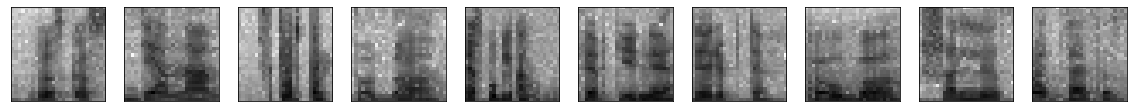

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
#################################
input_img = Input(shape=(28, 28, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
##################################
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
autoencoder.fit(db15_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(db20_test, db20_test)
                )

Train on 69071 samples, validate on 69075 samples
Epoch 1/100
69071/69071 [==============================] - 252s 4ms/sample - loss: 0.6832 - val_loss: 0.6887
Epoch 2/100
69071/69071 [==============================] - 254s 4ms/sample - loss: 0.6823 - val_loss: 0.6882
Epoch 3/100
69071/69071 [==============================] - 254s 4ms/sample - loss: 0.6814 - val_loss: 0.6876
Epoch 4/100
69071/69071 [==============================] - 251s 4ms/sample - loss: 0.6805 - val_loss: 0.6871
Epoch 5/100
69071/69071 [==============================] - 251s 4ms/sample - loss: 0.6795 - val_loss: 0.6865
Epoch 6/100
69071/69071 [==============================] - 270s 4ms/sample - loss: 0.6786 - val_loss: 0.6861
Epoch 7/100
69071/69071 [==============================] - 263s 4ms/sample - loss: 0.6777 - val_loss: 0.6857
Epoch 8/100
69071/69071 [==============================] - 305s 4ms/sample - loss: 0.6768 - val_loss: 0.6855
Epoch 9/100
69071/69071 [==============================] - 293s 4ms/sample - l

69071/69071 [==============================] - 271s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 76/100
69071/69071 [==============================] - 271s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 77/100
69071/69071 [==============================] - 272s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 78/100
69071/69071 [==============================] - 272s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 79/100
69071/69071 [==============================] - 273s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 80/100
69071/69071 [==============================] - 273s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 81/100
69071/69071 [==============================] - 272s 4ms/sample - loss: 0.6710 - val_loss: 0.6849
Epoch 82/100
69071/69071 [==============================] - 271s 4ms/sample - loss: 0.6709 - val_loss: 0.6849
Epoch 83/100
69071/69071 [==============================] - 273s 4ms/sample - loss: 0.6709 - val_loss: 0.6849
Epoch 84/100
69071/6907

In [14]:
decoded_imgs = autoencoder.predict(db20_test)

In [15]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [16]:
n = 10

for i in range(n):
    
    value = PSNR(db20_test[i], decoded_imgs[i]) 
    print(f"PSNR value is {value} dB")

PSNR value is 65.82948825283428 dB
PSNR value is 66.22432203903513 dB
PSNR value is 66.45773641829747 dB
PSNR value is 66.17477092530932 dB
PSNR value is 65.19189721822234 dB
PSNR value is 66.15490558290232 dB
PSNR value is 66.49547205324319 dB
PSNR value is 66.40818815980352 dB
PSNR value is 67.59678663957413 dB
PSNR value is 68.68452428530895 dB
